In [1]:
import matplotlib
import pandas as pd
import numpy as np
import scipy.stats as si
import sympy as sy
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import norm
pd.options.display.max_columns = None
os.chdir('C:/Users/regru/Desktop/Datasets/Airline_Tweet_Sentiment')

In [2]:
tweet =  pd.read_csv('Tweets.csv')

In [3]:
tweet.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
#drop tweet_id
tweet = tweet.drop(['tweet_id'],axis=1)
#pct missing values
tweet.isna().mean()

airline_sentiment               0.000000
airline_sentiment_confidence    0.000000
negativereason                  0.373087
negativereason_confidence       0.281284
airline                         0.000000
airline_sentiment_gold          0.997268
name                            0.000000
negativereason_gold             0.997814
retweet_count                   0.000000
text                            0.000000
tweet_coord                     0.930396
tweet_created                   0.000000
tweet_location                  0.323292
user_timezone                   0.329235
dtype: float64

In [5]:
#if NaN is > 50% then drop column
df = tweet.dropna(axis=1,thresh=.5*len(tweet))
#orignial df has 14 columns
#dropped 3 columns that contained 50% or more NaN. now df has 11
[len(tweet.columns.tolist()),len(df.columns.tolist())]

[14, 11]

In [6]:
#sentiment counts for all airlines
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [7]:
#counts of each airline
df['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

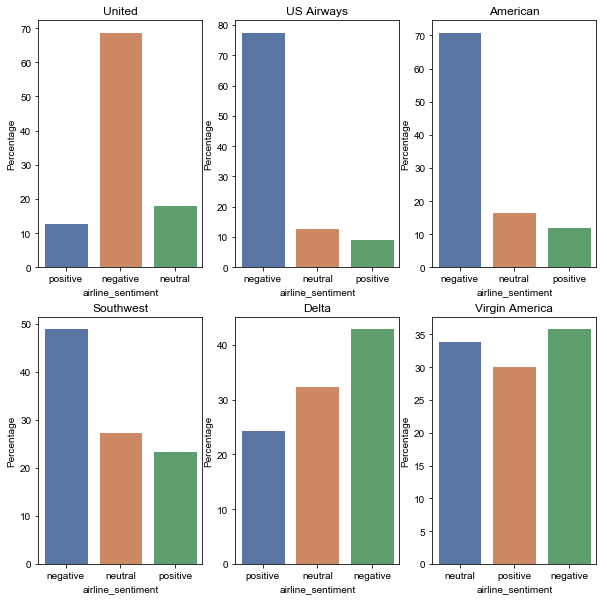

In [8]:
import warnings
warnings.filterwarnings("ignore")
#sentiment counts by airline
def pct_plots(Airline,Feature,loc1=0,loc2=0):
    data = df[df.airline == Airline]
    sns.set()
    sns.barplot(x=''+Feature,y=''+Feature,data=data, estimator=lambda x: len(x) / len(data) * 100,orient="v",ax=axes[loc1][loc2]).set(ylabel='Percentage',title=''+Airline)
#plot
f, axes = plt.subplots(2, 3,figsize=(10,10))
pct_plots('United','airline_sentiment',0,0)
pct_plots('US Airways','airline_sentiment',0,1)
pct_plots('American','airline_sentiment',0,2)
pct_plots('Southwest','airline_sentiment',1,0)
pct_plots('Delta','airline_sentiment',1,1)
pct_plots('Virgin America','airline_sentiment',1,2)
plt.show()

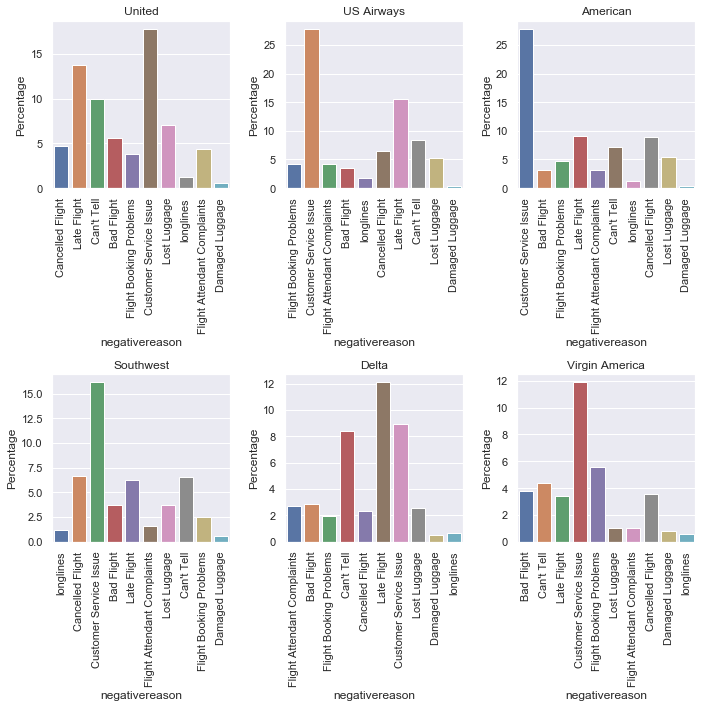

In [9]:
#pct of reason for negative rating by airline
f, axes = plt.subplots(2, 3,figsize=(10,10))
pct_plots('United','negativereason',0,0)
pct_plots('US Airways','negativereason',0,1)
pct_plots('American','negativereason',0,2)
pct_plots('Southwest','negativereason',1,0)
pct_plots('Delta','negativereason',1,1)
pct_plots('Virgin America','negativereason',1,2)
for ax in f.axes:
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [10]:
# remove stop words, special characters and uppercase letters
import re
import nltk
from nltk.corpus import stopwords
def remove_stopwords(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 


In [11]:
# create labels to predict negative sentiment
df['sentiment'] = df['airline_sentiment'].apply(lambda x: 0 if x == 'negative' else 1)

In [12]:
warnings.filterwarnings("ignore")
from sklearn.cross_validation import train_test_split
# remove characters and stop words from each tweet
df['clean_tweet'] = df['text'].apply(lambda x: remove_stopwords(x))
features = df['clean_tweet'].values
label = df['sentiment'].values
xtrain, xtest, ytrain, ytest = train_test_split(features,label,test_size=0.2,random_state=684)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
# setup tf-idf count vectorizer
tfidf_vec_train=TfidfVectorizer(lowercase=True)
tfidf_vec_test=TfidfVectorizer(lowercase=True)
# fit vectorizer
train_tfidf_vectors = tfidf_vec_train.fit_transform(xtrain)
test_tfidf_vectors = tfidf_vec_test.fit_transform(xtrain)

In [14]:
# get the first vector out (for the first document)
first_vector_tfidfvectorizer = train_tfidf_vectors[0]
# place tf-idf values in a pandas data frame
tf_idf_df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vec_train.get_feature_names(), columns=["tfidf"])
tf_idf_df.sort_values(by=["tfidf"],ascending=False)[0:10]

,tfidf
ubotmr,0.734212
update,0.439659
thanks,0.274415
http,0.270780
co,0.267797
jetblue,0.217465
presumably,0.000000
presented,0.000000
preparation,0.000000
preparations,0.000000


In [15]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [16]:
# Function to evaluate multiple models
from sklearn import pipeline,ensemble,preprocessing,feature_extraction,cross_validation,metrics
def nlp_pipeline(xtrain,ytrain,xtest,ytest,transformer,classifiers_list):
    for classifier in classifiers_list:
        clf = pipeline.Pipeline([('transformer', transformer),('classifier', classifier)])
        clf.fit(xtrain,ytrain)
        pred = clf.predict(xtest)
        #accuracy = accuracy_score(pred,ytest)
        auc = roc_auc_score(ytest, clf.predict_proba(xtest)[:,1])
        print('AUC Score for '+classifier.__class__.__name__+' is '+str(auc))

In [17]:
# establish transformer and classifiers list
tran = feature_extraction.text.TfidfVectorizer(use_idf=True)
Classifiers = [
    LogisticRegression(C=0.001,solver='liblinear',max_iter=200),
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200)]

In [18]:
nlp_pipeline(xtrain,ytrain,xtest,ytest,tran,Classifiers)

AUC Score for LogisticRegression is 0.8473097510028721
AUC Score for KNeighborsClassifier is 0.7842588636489511
AUC Score for SVC is 0.8631752078932169
AUC Score for DecisionTreeClassifier is 0.7133345893960613
AUC Score for RandomForestClassifier is 0.8894410125250223


In [19]:
# Use best performing model
from sklearn import pipeline,ensemble,preprocessing,feature_extraction,cross_validation,metrics
clf = pipeline.Pipeline([
        ('tfidf_vectorizer', feature_extraction.text.TfidfVectorizer(use_idf=True)),
        ('rf_classifier', ensemble.RandomForestClassifier(n_estimators=200,n_jobs=-1))])

In [20]:
# Fit model
clf.fit(xtrain,ytrain)

Pipeline(memory=None,
     steps=[('tfidf_vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [21]:
preds=clf.predict(xtest)
# confusion matrix for randomforest
pd.crosstab(ytest, preds, rownames=['Actual'], colnames=['Predicted'], margins=True,normalize='all')

Predicted,0,1,All
Actual,,,
0,0.560792,0.058060,0.618852
1,0.128415,0.252732,0.381148
All,0.689208,0.310792,1.000000


In [22]:
accuracy_score(ytest, preds)

0.8135245901639344